# Am I feeding my network crap

Given that my research on the image content of optical flow images shows such huge variety is my image generation doing  anything useful to it??? Perhaps experiment with a very small network for say only 10 classes?? 

First lets look at the output for something relatively easy like cricket 

In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Is it the data or my classifier

I am starting to wonder what it is about my optical flow data that might be causing so much easier. Regardless about the unconverged flow images I feel the author of the data still managed with it. So there's essentially two things I can either get a large amount of improvement simply on how I train my classifier (slower?), or my data set is not quite right. I've already seen that I wasn't even doing any random transforms on my opt flow images courtesy my badly written opt flow data generator. 
Any how what I am aiming to do is use a stinkingly cheap data model to explore what might be wrong. 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(101))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [8]:
model_fast_lr = getModel(lr=1e-2)

In [9]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01.txt', \
                       '../../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [10]:
mod1 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=5,
                    verbose=1)

Epoch 1/5
64/64 [==============================] - 101s 2s/step - loss: 4.6109 - acc: 0.0098 - val_loss: 4.6060 - val_acc: 0.0059
Epoch 2/5
64/64 [==============================] - 90s 1s/step - loss: 4.6041 - acc: 0.0123 - val_loss: 4.6013 - val_acc: 0.0096
Epoch 3/5
64/64 [==============================] - 100s 2s/step - loss: 4.6013 - acc: 0.0132 - val_loss: 4.5965 - val_acc: 0.0146
Epoch 4/5
64/64 [==============================] - 95s 1s/step - loss: 4.5950 - acc: 0.0133 - val_loss: 4.5938 - val_acc: 0.0131
Epoch 5/5
64/64 [==============================] - 94s 1s/step - loss: 4.5930 - acc: 0.0184 - val_loss: 4.5885 - val_acc: 0.0210


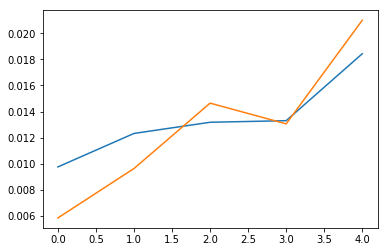

In [11]:
plt.plot(mod1.history['acc'])
plt.plot(mod1.history['val_acc'])

In [12]:
mod2 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=32,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
64/64 [==============================] - 71s 1s/step - loss: 4.5923 - acc: 0.0161 - val_loss: 4.5857 - val_acc: 0.0164
Epoch 2/20
64/64 [==============================] - 71s 1s/step - loss: 4.5885 - acc: 0.0206 - val_loss: 4.5818 - val_acc: 0.0203
Epoch 3/20
64/64 [==============================] - 64s 996ms/step - loss: 4.5866 - acc: 0.0199 - val_loss: 4.5799 - val_acc: 0.0244
Epoch 4/20
64/64 [==============================] - 67s 1s/step - loss: 4.5814 - acc: 0.0236 - val_loss: 4.5793 - val_acc: 0.0322
Epoch 5/20
64/64 [==============================] - 69s 1s/step - loss: 4.5771 - acc: 0.0217 - val_loss: 4.5772 - val_acc: 0.0293
Epoch 6/20
64/64 [==============================] - 70s 1s/step - loss: 4.5747 - acc: 0.0242 - val_loss: 4.5675 - val_acc: 0.0327
Epoch 7/20
64/64 [==============================] - 65s 1s/step - loss: 4.5720 - acc: 0.0233 - val_loss: 4.5656 - val_acc: 0.0295
Epoch 8/20
64/64 [==============================] - 62s 971ms/step - loss: 4.5711 - acc

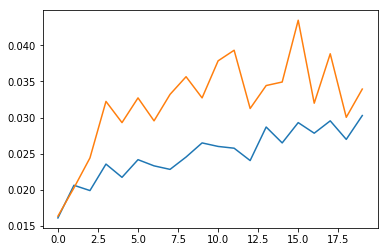

In [14]:
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])

In [15]:
from motion_network import getSimonyanOxfordModel
from keras.optimizers import SGD

In [21]:
simonyan_model=getSimonyanOxfordModel((224,224,2), 101, printmod=0)

In [22]:
mypotim = SGD(lr=0.5e-2, momentum=0.9)
simonyan_model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [26]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 256,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':256,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01.txt', \
                       '../../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [24]:
mod2 = simonyan_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, 
                    use_multiprocessing=True,
                    workers=2, epochs=5,
                    verbose=1)

Epoch 1/5
37/37 [==============================] - 87s 2s/step - loss: 4.8016 - acc: 0.0096 - val_loss: 4.7630 - val_acc: 0.0092
Epoch 2/5
37/37 [==============================] - 73s 2s/step - loss: 4.7630 - acc: 0.0105 - val_loss: 4.7625 - val_acc: 0.0103
Epoch 3/5
37/37 [==============================] - 74s 2s/step - loss: 4.7624 - acc: 0.0115 - val_loss: 4.7619 - val_acc: 0.0126
Epoch 4/5
37/37 [==============================] - 84s 2s/step - loss: 4.7616 - acc: 0.0098 - val_loss: 4.7613 - val_acc: 0.0098
Epoch 5/5
37/37 [==============================] - 74s 2s/step - loss: 4.7611 - acc: 0.0119 - val_loss: 4.7610 - val_acc: 0.0098


In [25]:
mod2 = simonyan_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, 
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
37/37 [==============================] - 77s 2s/step - loss: 4.7614 - acc: 0.0117 - val_loss: 4.7604 - val_acc: 0.0100
Epoch 2/20
37/37 [==============================] - 71s 2s/step - loss: 4.7606 - acc: 0.0109 - val_loss: 4.7599 - val_acc: 0.0100
Epoch 3/20
37/37 [==============================] - 74s 2s/step - loss: 4.7595 - acc: 0.0103 - val_loss: 4.7596 - val_acc: 0.0098
Epoch 4/20
37/37 [==============================] - 74s 2s/step - loss: 4.7599 - acc: 0.0105 - val_loss: 4.7589 - val_acc: 0.0106
Epoch 5/20
37/37 [==============================] - 73s 2s/step - loss: 4.7583 - acc: 0.0125 - val_loss: 4.7589 - val_acc: 0.0114
Epoch 6/20
37/37 [==============================] - 73s 2s/step - loss: 4.7584 - acc: 0.0132 - val_loss: 4.7583 - val_acc: 0.0106
Epoch 7/20
37/37 [==============================] - 73s 2s/step - loss: 4.7581 - acc: 0.0115 - val_loss: 4.7578 - val_acc: 0.0112
Epoch 8/20
37/37 [==============================] - 71s 2s/step - loss: 4.7583 - acc: 0.01

In [29]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01.txt', \
                       '../../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [30]:
simonyan_model2=getSimonyanOxfordModel((224,224,2), 101, printmod=0)

In [34]:
mypotim = SGD(lr=1e-3, momentum=0.9)
simonyan_model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])
mod2 = simonyan_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator, 
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 84s 283ms/step - loss: 4.7782 - acc: 0.0113 - val_loss: 4.7620 - val_acc: 0.0140
Epoch 2/20
298/298 [==============================] - 79s 266ms/step - loss: 4.7634 - acc: 0.0100 - val_loss: 4.7613 - val_acc: 0.0098
Epoch 3/20
298/298 [==============================] - 81s 270ms/step - loss: 4.7625 - acc: 0.0113 - val_loss: 4.7607 - val_acc: 0.0101
Epoch 4/20
298/298 [==============================] - 78s 262ms/step - loss: 4.7601 - acc: 0.0127 - val_loss: 4.7599 - val_acc: 0.0103
Epoch 5/20
298/298 [==============================] - 81s 273ms/step - loss: 4.7599 - acc: 0.0114 - val_loss: 4.7589 - val_acc: 0.0159
Epoch 6/20
298/298 [==============================] - 76s 254ms/step - loss: 4.7601 - acc: 0.0123 - val_loss: 4.7586 - val_acc: 0.0138
Epoch 7/20
298/298 [==============================] - 73s 244ms/step - loss: 4.7605 - acc: 0.0099 - val_loss: 4.7580 - val_acc: 0.0117
Epoch 8/20
298/298 [==============================] - 7

In [38]:
from keras import regularizers
def getSimonyanOxfordModelNoBN(input_shape, n_classes, printmod=1, dropout=1):
    model = Sequential()
    weight_decay = 1e-4
    model.add(Conv2D(96, (7,7), strides=2, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, (5,5), strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.9))
    
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.9))      
    
    model.add(Dense(n_classes, activation='softmax'))
                         
    if (printmod==1 ):
        model.summary()
    
    return model

In [41]:
simonyan_model_no_bn=getSimonyanOxfordModelNoBN((224,224,2), 101, printmod=0)

In [42]:
mypotim = SGD(lr=1e-2, momentum=0.9)
simonyan_model_no_bn.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])
mod2 = simonyan_model_no_bn.fit_generator(generator=training_generator,
                    validation_data=validation_generator, 
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 71s 238ms/step - loss: 4.7745 - acc: 0.0122 - val_loss: 4.7559 - val_acc: 0.0130
Epoch 2/20
298/298 [==============================] - 67s 226ms/step - loss: 4.7689 - acc: 0.0106 - val_loss: 4.7536 - val_acc: 0.0130
Epoch 3/20
298/298 [==============================] - 67s 225ms/step - loss: 4.7616 - acc: 0.0127 - val_loss: 4.7514 - val_acc: 0.0114
Epoch 4/20
298/298 [==============================] - 68s 227ms/step - loss: 4.7556 - acc: 0.0128 - val_loss: 4.7496 - val_acc: 0.0117
Epoch 5/20
298/298 [==============================] - 69s 233ms/step - loss: 4.7546 - acc: 0.0118 - val_loss: 4.7480 - val_acc: 0.0117
Epoch 6/20
298/298 [==============================] - 69s 233ms/step - loss: 4.7493 - acc: 0.0111 - val_loss: 4.7464 - val_acc: 0.0117
Epoch 7/20
298/298 [==============================] - 69s 232ms/step - loss: 4.7473 - acc: 0.0110 - val_loss: 4.7446 - val_acc: 0.0117
Epoch 8/20
298/298 [==============================] - 7

Process ForkPoolWorker-554:
Process ForkPoolWorker-553:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, *

KeyboardInterrupt: 

  File "/data/su_buildup/two_stream_part2/utils/optical_flow_data_gen.py", line 79, in __data_generation
    data = self.__data_load(ID)
KeyboardInterrupt
  File "/data/su_buildup/two_stream_part2/utils/optical_flow_data_gen.py", line 116, in __data_load
    v_img = cv2.imread(v_file, 0)
